## Dataset

Veamos estadísticas y otras cosas del dataset

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import django
from tqdm.auto import tqdm

os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

sys.path.append("..")
os.environ['DJANGO_SETTINGS_MODULE'] = 'news_labelling.settings'
django.setup()

from api.models import Comment, ArticleLabel, CommentLabel, Article, Batch
from django.contrib.auth.models import User

In [2]:
from django.db.models import Count, Case, When, Value

annotated_articles = Article.objects.exclude(batch__name="training").annotate(
    num_labels=Count('labels'),
    effective_labels=Count(
        Case(When(labels__is_interesting=True, then=Value(1)))
    )
)


dataset_articles = annotated_articles.filter(effective_labels=3)

skipped = 0

for art in annotated_articles:
    if art.num_labels > art.effective_labels:
        skipped +=1


print(f"Artículos totales: {Article.objects.count()}")
print(f"Artículos con 3 anotaciones: {dataset_articles.count()}")
print(f"Artículos con alguna anotación: {annotated_articles.filter(num_labels__gte=1).count()}")
print(f"Artículos que no pasaron a tercera anotación: {skipped}")

Artículos totales: 1738
Artículos con 3 anotaciones: 1238
Artículos con alguna anotación: 1725
Artículos que no pasaron a tercera anotación: 452


Carguemos directamente el JSON generado

In [3]:
import json

with open("../output/dataset.raw.json") as f:
    raw_articles = json.load(f)
print(len(raw_articles))


1238


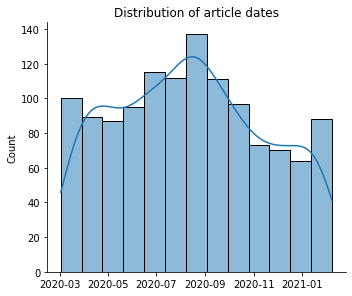

In [4]:
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

dates = [datetime.fromisoformat(d["date"].replace('Z', '+00:00')) for d in raw_articles]

ax = sns.displot(
    x=dates, 
    kde=True, 
    height=4, aspect=1.25,
)

plt.title("Distribution of article dates")
plt.savefig("figures/date_distribution.png", bbox_inches='tight')

In [5]:
from django.db.models import Sum
import pandas as pd

df_articles = pd.DataFrame(raw_articles)
df_articles.set_index("tweet_id", inplace=True)

df_articles["comments"] = df_articles["comments"].apply(lambda l: len(l))

df_count = df_articles.groupby("news")[["comments"]].sum()
df_count["articles"] = df_articles.groupby("news")["comments"].count()


df_count.loc["total"] = df_count.sum()

df_count

,comments,articles
news,,
LANACION,10378,222
clarincom,17501,370
cronica,1562,42
infobae,26834,590
perfilcom,594,14
total,56869,1238


In [6]:
print(df_count.to_latex())

\begin{tabular}{lrr}
\toprule
{} &  comments &  articles \\
news      &           &           \\
\midrule
LANACION  &     10378 &       222 \\
clarincom &     17501 &       370 \\
cronica   &      1562 &        42 \\
infobae   &     26834 &       590 \\
perfilcom &       594 &        14 \\
total     &     56869 &      1238 \\
\bottomrule
\end{tabular}



In [7]:


comments = [
{
    **{"article_id": art["tweet_id"]},
    **comment
} for art in raw_articles for comment in art["comments"]]


[]

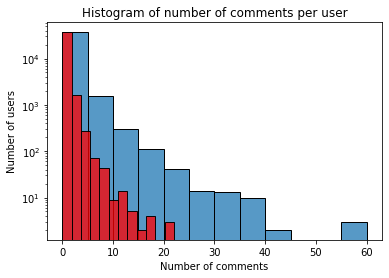

In [8]:
df_comments = pd.DataFrame(comments)
df_comments["one_hateful"] = df_comments["HATEFUL"].apply(lambda x: len(x) > 0)

user_counts = df_comments["user_id"].value_counts().to_frame("comments")
hateful_counts = df_comments[df_comments["one_hateful"]]["user_id"].value_counts().to_frame("hateful_comments")

data = pd.concat([user_counts, hateful_counts]).fillna(0).astype(int)
sns.histplot(data=data, x="comments", hue=None, bins=12)
sns.histplot(data=data, x="hateful_comments", hue=None, bins=12, color="red")

plt.ylabel("Number of users")
plt.xlabel("Number of comments")
plt.title("Histogram of number of comments per user")
plt.semilogy()

In [9]:
hateful = data[data["hateful_comments"] > 0]

hateful.mean(), hateful.std()

(comments            0.000000
 hateful_comments    1.441234
 dtype: float64,
 comments            0.000000
 hateful_comments    1.238882
 dtype: float64)

In [10]:
(hateful["hateful_comments"] > 10).sum()

28

Text(0.5, 1.0, 'Histogram of hateful annotations per comment')

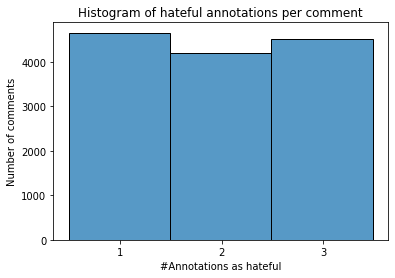

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

votes = [len(c['HATEFUL']) for c in comments if c['HATEFUL']]

sns.histplot(x=votes, bins=[0.99, 1.99, 2.99, 3.99])

plt.xticks([1.5, 2.5, 3.5], [1, 2, 3])
plt.xlabel("#Annotations as hateful")
plt.ylabel("Number of comments")
plt.title("Histogram of hateful annotations per comment")

In [12]:
possibly_hateful = len([c for c in comments if len(c['HATEFUL']) > 0])
hateful = len([c for c in comments if len(c['HATEFUL']) >= 2])

full_agreement = len([c for c in comments if len(c['HATEFUL']) == 3])

print(f"Comentarios totales                             : {len(comments)}")
print(f"Comentarios con >= 1 etiqueta de discriminación : {possibly_hateful}")
print(f"Comentarios con >= 2 etiqueta de discriminación : {hateful}")
print(f"Comentarios con >= 3 etiqueta de discriminación : {full_agreement}")
print(f"Ratio de comentarios odiosos (>= 2) sobre totales = {hateful / len(comments):.3f}")

Comentarios totales                             : 56869
Comentarios con >= 1 etiqueta de discriminación : 13366
Comentarios con >= 2 etiqueta de discriminación : 8715
Comentarios con >= 3 etiqueta de discriminación : 4514
Ratio de comentarios odiosos (>= 2) sobre totales = 0.153


## Agreement

Uso el código que ya hice con los objetos de Django que es más cómodo...

In [13]:
from api.metrics import AgreementCalculator

calculator = AgreementCalculator(articles=dataset_articles)

In [14]:
calculator.users = None

In [15]:
categories = [
    'HATE',
    'CALLS',
    'MUJER',
    'LGBTI',
    'RACISMO',
    'POBREZA',
    'DISCAPACIDAD',
    'POLITICA',
    'ASPECTO',
    'CRIMINAL',
]

agreement_df = pd.DataFrame([{
    "Category": category,
    "Agreement": calculator.get_agreement(on=category)[0],
} for category in categories])
agreement_df.set_index("Category")

,Agreement
Category,
HATE,0.579610
CALLS,0.641360
MUJER,0.783391
LGBTI,0.920701
RACISMO,0.929094
POBREZA,0.706778
DISCAPACIDAD,0.849856
POLITICA,0.808519
ASPECTO,0.871752


Lo calculamos de nuevo por si acaso

In [16]:
keys = [
 'HATEFUL',
 'CALLS',
 'WOMEN',
 'LGBTI',
 'RACISM',
 'CLASS',
 'POLITICS',
 'DISABLED',
 'APPEARANCE',
 'CRIMINAL',
]

annotators = set(annotator for article in raw_articles for comment in article["comments"] for annotator in comment["annotators"])

idx = pd.MultiIndex.from_product(
    [keys, annotators],
    names=["categoria", "etiquetador"]
)
comment_ids = [comment["id"] for article in raw_articles for comment in article["comments"]]

my_df = pd.DataFrame(index=idx, columns=comment_ids)

for article in tqdm(raw_articles):
    for comment in article["comments"]:
        for annotator in comment["annotators"]:
            is_hateful = annotator in comment["HATEFUL"]
            my_df.loc[("HATEFUL", annotator), comment["id"]] = is_hateful
            
            if is_hateful:
                for key in keys[1:]:
                    my_df.loc[(key, annotator), comment["id"]] =  annotator in comment[key]

100%|██████████| 1238/1238 [00:44<00:00, 27.87it/s]


In [17]:
import krippendorff

alphas = {key:krippendorff.alpha(my_df.loc[key].values.astype(float)) for key in keys}

print(pd.DataFrame([alphas]).T.sort_values(0).to_latex())
    


\begin{tabular}{lr}
\toprule
{} &         0 \\
\midrule
HATEFUL    &  0.579610 \\
CALLS      &  0.641360 \\
CLASS      &  0.706778 \\
WOMEN      &  0.783391 \\
POLITICS   &  0.808519 \\
DISABLED   &  0.849856 \\
APPEARANCE &  0.871752 \\
LGBTI      &  0.920701 \\
RACISM     &  0.929094 \\
CRIMINAL   &  0.931163 \\
\bottomrule
\end{tabular}



Obs: acá los agreements por categorías se ven sólo en aquellos comentarios que son marcados como odiosos, y sólo entre aquellos anotadores que hayan marcado como odioso

En términos de cómo calculamos el alpha de Krippendorff: supongamos que estamos calculando el agreement de MUJER. Si anotador A1 y A2 marcaron como odioso C1, y ambos marcaron mujer => en ambos va 1. Anotador A3 no marcó como odioso ese comentario => va nan. En C2, A1 no marcó como odioso y A2 y A3 marcaron como odioso contra MUJER. En C3, A3 no marcó odioso, y A1 sí pero sin marcar MUJER y A2 marcó odioso y MUJER.

La matriz quedaría así:

|   |C1   |C2    | C3   |
|---|-----|------|------|
|A1 | 1   | nan  | 0    |
|A2 | 1   | 1    | 1    |
|A3 | nan | 1    | nan  |

## Máxima performance esperada

Calculemos el F1 promedio entre anotadores, usando las anotaciones de uno y otro como estándar

434

In [34]:
from sklearn.metrics import f1_score
import numpy as np
import json

test_ids = json.load(open("test_ids.json"))

annotators = my_df.loc["HATEFUL"].index


max_performance = {}

for key in keys:
    print("="*80)
    print(key)

    scores = []

    for i in range(len(annotators)):
        for j in range(i+1, len(annotators)):
            a1 = annotators[i]
            a2 = annotators[j]

            tweets_both_annotated = my_df.loc[(key, a1)].notna() & my_df.loc[(key, a2)].notna()

            tweets_both_annotated = (tweets_both_annotated & tweets_both_annotated.index.isin(test_ids))
            a1_annotations = my_df.loc[(key, a1), tweets_both_annotated]
            a2_annotations = my_df.loc[(key, a2), tweets_both_annotated]

            assert a1_annotations.isna().sum() == 0
            assert a2_annotations.isna().sum() == 0


            score = f1_score(a1_annotations.values.astype(int), a2_annotations.values.astype(int), average="binary")
            
            scores.append(score)
            #print(f"F1 between {a1} - {a2} = {score:.3f}")
            
    print(f"F1 promedio = {np.array(scores).mean():.3f}")
    print(f"F1 mediana  = {sorted(scores)[len(scores)//2]}")

HATEFUL
F1 promedio = 0.653
F1 mediana  = 0.675110829639012
CALLS
F1 promedio = 0.604
F1 mediana  = 0.7037037037037037
WOMEN
F1 promedio = 0.726
F1 mediana  = 0.736842105263158
LGBTI
F1 promedio = 0.894
F1 mediana  = 0.9600000000000001
RACISM
F1 promedio = 0.946
F1 mediana  = 0.9592760180995475
CLASS
F1 promedio = 0.731
F1 mediana  = 0.7499999999999999
POLITICS


/home/jmperez/.local/share/virtualenvs/news-labelling-8oK1LTa4/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1495: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


F1 promedio = 0.737
F1 mediana  = 0.7777777777777778
DISABLED


/home/jmperez/.local/share/virtualenvs/news-labelling-8oK1LTa4/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1495: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/home/jmperez/.local/share/virtualenvs/news-labelling-8oK1LTa4/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1495: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


F1 promedio = 0.797
F1 mediana  = 0.88
APPEARANCE
F1 promedio = 0.803
F1 mediana  = 0.9024390243902439
CRIMINAL
F1 promedio = 0.818
F1 mediana  = 0.9473684210526315


/home/jmperez/.local/share/virtualenvs/news-labelling-8oK1LTa4/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1495: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/home/jmperez/.local/share/virtualenvs/news-labelling-8oK1LTa4/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1495: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


,327916,327917,327918,327919,327920,327921,327922,327923,327924,327925,...,407945,407946,407947,407948,407949,407950,407951,407952,407953,407954
HATEFUL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CALLS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WOMEN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LGBTI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RACISM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CLASS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
POLITICS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DISABLED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
APPEARANCE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CRIMINAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


327934    2
327941    1
336914    1
336920    3
336921    0
         ..
407935    0
407939    0
407948    0
407949    0
407954    0
Length: 8715, dtype: object

In [65]:
#three_times = my_df.loc["HATEFUL"].notna().sum() == 3

gold_label = pd.DataFrame(columns=my_df.columns, index=keys)

gold_label.loc["HATEFUL"] = my_df.loc["HATEFUL"].fillna(False).sum() >= 2
gold_label.loc["CALLS"] = my_df.loc["CALLS"].fillna(False).sum() >= 2

hateful = gold_label.columns[gold_label.loc["HATEFUL"]]

for key in keys[2:]:
    gold_label.loc[key, hateful] = my_df.loc[key, hateful].fillna(0).sum() > 0

for key in keys:
    print("="*80)
    print(key)

    scores = []

    for i in range(len(annotators)):
        a1 = annotators[i]

        tweets_both_annotated = my_df.loc[(key, a1)].notna()
        tweets_both_annotated = (tweets_both_annotated & tweets_both_annotated.index.isin(test_ids))

        if key not in {"HATEFUL", "CALLS"}:
            tweets_both_annotated = tweets_both_annotated & tweets_both_annotated.index.isin(hateful)

        a1_annotations = my_df.loc[(key, a1), tweets_both_annotated]
        a2_annotations = gold_label.loc[key, tweets_both_annotated]

        assert a1_annotations.isna().sum() == 0
        assert a2_annotations.isna().sum() == 0

        score = f1_score(a1_annotations.values.astype(int), a2_annotations.values.astype(int), average="binary")
            
        scores.append(score)
        #print(f"F1 between {a1} - {a2} = {score:.3f}")
            
    print(f"F1 promedio = {np.array(scores).mean():.3f}")
    print(f"F1 mediana  = {sorted(scores)[len(scores)//2]}")


HATEFUL
F1 promedio = 0.829
F1 mediana  = 0.8515463917525773
CALLS
F1 promedio = 0.774
F1 mediana  = 0.9148264984227129
WOMEN
F1 promedio = 0.837
F1 mediana  = 0.8275862068965517
LGBTI
F1 promedio = 0.966
F1 mediana  = 0.9743589743589743
RACISM
F1 promedio = 0.967
F1 mediana  = 0.9731958762886598
CLASS
F1 promedio = 0.806
F1 mediana  = 0.8391608391608391
POLITICS
F1 promedio = 0.892
F1 mediana  = 0.9189189189189189
DISABLED
F1 promedio = 0.898
F1 mediana  = 0.9392265193370166
APPEARANCE
F1 promedio = 0.903
F1 mediana  = 0.9493087557603688
CRIMINAL
F1 promedio = 0.961
F1 mediana  = 0.9788867562380038


In [43]:
a1_annotations.values.astype(int)

array([0, 0, 1, ..., 1, 0, 0])

In [40]:
scores

[array([0.89284965, 0.56061909]),
 array([0.70779977, 0.56271777]),
 array([0.74667709, 0.55062413]),
 array([0.86533333, 0.52803738]),
 array([0.8520841 , 0.59617321]),
 array([0.8085456 , 0.68183887]),
 array([0.82336383, 0.60933852]),
 array([0.88297872, 0.73207547]),
 array([0.91466475, 0.67808837]),
 array([0.82067459, 0.80161074]),
 array([0.81661486, 0.72765422]),
 array([0.79971285, 0.73802817]),
 array([0.79476156, 0.64726611]),
 array([0.7712858 , 0.65225015]),
 array([0.91069522, 0.68403261])]

In [24]:
sorted(scores)

[0.5280373831775701,
 0.550624133148405,
 0.5606190885640585,
 0.5627177700348432,
 0.596173212487412,
 0.6093385214007783,
 0.6472661134477662,
 0.652250146113384,
 0.6780883678990081,
 0.6818388711879837,
 0.6840326108570292,
 0.7276542173730594,
 0.732075471698113,
 0.7380281690140844,
 0.8016107382550336]

## Modo estricto

No asignamos "nan" si no marcó hateful, marcamos 0

In [ ]:


characteristics = [
 'WOMEN',
 'LGBTI',
 'RACISM',
 'CLASS',
 'POLITICS',
 'DISABLED',
 'APPEARANCE',
 'CRIMINAL',
]

annotators = set(annotator for article in raw_articles for comment in article["comments"] for annotator in comment["annotators"])

idx = pd.MultiIndex.from_product(
    [keys, annotators],
    names=["categoria", "etiquetador"]
)
comment_ids = [comment["id"] for article in raw_articles for comment in article["comments"]]

strict_df = pd.DataFrame(index=idx, columns=comment_ids)

for article in tqdm(raw_articles):
    for comment in article["comments"]:
        for annotator in comment["annotators"]:
            is_hateful = annotator in comment["HATEFUL"]
            strict_df.loc[("HATEFUL", annotator), comment["id"]] = is_hateful
            for key in characteristics:
                strict_df.loc[(key, annotator), comment["id"]] =  annotator in comment[key]
                

strict_alphas = {key:krippendorff.alpha(strict_df.loc[key].values.astype(float)) for key in characteristics}

pd.DataFrame([strict_alphas]).T.sort_values(0).to_latex()

In [ ]:
pd.DataFrame([strict_alphas]).T.sort_values(0)

## Algunos ejemplos

Leamos ahora el ya asignado

In [ ]:
with open("../output/dataset.json") as f:
    articles = json.load(f)
    
comments = [{**comm, **{"article": art}} for art in articles for comm in art["comments"]]

In [ ]:
import random

char_tweets = {char:[] for char in keys[1:] if char != "CALLS"}

for comment in comments:
    for key in char_tweets:
        if comment[key]:
            char_tweets[key].append(comment)

# Esto es medio trucho pero bueno

#for arr in char_tweets.values():
#    random.shuffle(arr)

df_count = pd.DataFrame([
    {
        "Characteristic": k,
        "Count":len(v),
        "Calls to Action": len([c for c in v if c["CALLS"]])
    } for k, v in char_tweets.items()])

df_count.set_index("Characteristic", inplace=True)
df_count.sort_values("Count", inplace=True, ascending=False)

df_count

In [ ]:
print(df_count.to_latex())

In [ ]:
import random

random.seed(2021)

data = []

selected_ids = {
    "WOMEN": {
        407976, 371887, 407372, 350369, 404390, 354563, 360696, 408112, 387787, 406491, 
        333431, 333380, 366020
    },
    "LGBTI": {348304, 401013, 396655, 369370, 365953, 397528, 377415, 394007, 400769},
    "RACISM": {345526, 346189, 361417, 348501, 407751, 403677, 376555, 342786, 338586},
    "CRIMINAL": {385282, 343734, 359714, 367753, 374584},
    "CLASS": {344236, 335045, 355946, 379401, 345243, 353042, 331749, 367136},
    
    "POLITICS": {364045, 382819, 368191, 405420, 365289},
    "APPEARANCE": {377430, 389419, 401537, 352592, 368514},
    "DISABLED": {373983, 329510, 369358, 397780},
    
    "CALLS": {345395, 361092, 370678, 339375, 403667, 379905, 370694, },
}

for char, tweets in char_tweets.items():
    print(f"\n\n## {char}", "\n" * 3)
    random.shuffle(tweets)
    for tweet in tweets[:25]:
        article = tweet["article"]
        print(f"- ({tweet['id']}) {tweet['text']} |||| {article['title']}")
        data.append({
            "article_id": article['tweet_id'],
            "comment_id": comment["id"],
            "characteristic": char,
            "text": tweet['text'], 
            "context": article['title'],
        })

In [ ]:
pd.options.display.max_colwidth = 240
pd.options.display.max_rows = 120

id2comment = {comment["id"]:comment for comment in comments}

data = []

for characteristic, comment_ids in selected_ids.items():
    for comment_id in comment_ids:
        comment = id2comment[comment_id]
        article = comment["article"]
        data.append({
            "comment_id": comment_id,
            "characteristic": characteristic,
            "context": article["title"],
            "text": comment["text"],
            
        })
df_selected = pd.DataFrame(data)

df_selected

In [ ]:
df

In [ ]:
import re
pd.options.display.max_colwidth = 256

#sub_data = [d for d in data if d["characteristic"] in {"WOMEN", "LGBTI"}]

sub_data = df_selected

df_char = pd.DataFrame(sub_data)[["characteristic", "context", "text"]]
table = df_char.to_latex(index=False, col_space=1)

table = re.sub(r"&\s+", "& ", table)

print(table)

In [ ]:
data[0]